In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_31865/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [3]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [4]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [5]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'hemocardiacoutputst', 'hrsevfailcreatinine', 'num_prev_tx', 'hemocardiacindexst', 'microsph', 'percent_intelligibility', 'init_wgt_kg', 'extmcsddopaminedt', 'skin_squamous_donor', 'pretitera', 'mcsdwithouthemosbp', 'num_acute_rej_epi', 'extfailedweaningattempt', 'num_li_disc', 'init_current_pra', 'val_dt_ldr', 'currtherdopamine', 'tumor_size3', 'renal_car_donor', 'criteriamcsdwithai', 'currthervasopressin', 'oth_life_sup_tcr', 'doncrit_final_creat_import', 'extinomuldobutamine', 'method_blood_sugar_control_pa', 'cold_isch_ki', 'end_epts', 'a2a2b_eligibility', 'sendatacpra', 'request_score', 'calc_serum', 'extinvasivecatheter', 'artificial_li_tcr', 'inotropes_tcr', 'pa_preserv_tm', 'serum_sodium', 'req2_cardiomyopathy', 'fev_post_pct', 'ethnicity_don', 'inotropeepinephrine', 'init_match_las', 'init_peak_pra', 'role_phys_score', 'mcsdwithhemo', 'candhistnumsternotomies', 'drug16_days', 'malig_don_rel_12_dx_date', 'hemomeanpressure', 'thyroid', 'totisch', 'mcsdwithout

Let's investigate the columns with unknown type.

In [6]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [7]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'leflunomide_ind', 'antitnf_maint', 'xomazymecd5_ind', 'okt3_ind', 'envarsusxr_maint', 'sandimmune_ind', 'nulojix_maint', 'genericcyclosporin_ind', 'gengraf_maint', 'rapamune_ind', 'cyclosporin_maint', 'campath_ind', 'cytoxan_ind', 'campath_maint', 'il1receptorantagonist_ind', 'genericsirolimus_ind', 'rapamune_maint', 'oth_drug_maint2', 'cellcept_ind', 'methotrexate_ind', 'antiil6_ind', 'sandimmune_maint', 'okt4_ind', 'brequinarsodium_ind', 'antilfa1_ind', 'steroids_maint', 'eon_maint', 'genericcyclosporin_maint', 'nratgnrats_ind', 'envarsusxr_ind', 'steroids_ind', 'thymoglobulin_maint', 'solubleil1receptor_ind', 'il1receptorantagonist_maint', 'aldesleukin_ind', 'imuran_ind', 'okt4_maint', 'thymoglobulin_ind', 'genericmyfortic_ind', 'zenapax_maint', 'fty720_maint', 'zenapax_ind', 'deoxyspergualin_maint', 'methotrexate_maint', 'atgam_maint', 

Let's investigate the types of these columns.

In [8]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

0.00000    10
1.00000     6
Name: leflunomide_ind, dtype: int64
0.00000    7
Name: antitnf_maint, dtype: int64
0.00000    6
Name: xomazymecd5_ind, dtype: int64
1.00000    3441
0.00000    1008
Name: okt3_ind, dtype: int64
1.00000    88
Name: envarsusxr_maint, dtype: int64
0.00000    2106
1.00000    1255
Name: sandimmune_ind, dtype: int64
1.00000    13
Name: nulojix_maint, dtype: int64
0.00000    255
1.00000      2
Name: genericcyclosporin_ind, dtype: int64
1.00000    2072
0.00000      29
Name: gengraf_maint, dtype: int64
0.00000    983
1.00000    134
Name: rapamune_ind, dtype: int64
1.00000    10117
0.00000      152
Name: cyclosporin_maint, dtype: int64
1.00000    500
0.00000      2
Name: campath_ind, dtype: int64
0.00000    271
1.00000    138
Name: cytoxan_ind, dtype: int64
0.00000    502
Name: campath_maint, dtype: int64
1.00000    7
0.00000    2
Name: il1receptorantagonist_ind, dtype: int64
0.00000    11
1.00000     1
Name: genericsirolimus_ind, dtype: int64
1.00000    1025
0.00000  

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [9]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [10]:
# sort columns by number of unique values
categoric_sorted_unique = d[categorical_columns & set(d.columns)].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

/tmp/ipykernel_31865/1105790879.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  categoric_sorted_unique = d[categorical_columns & set(d.columns)].nunique().sort_values(ascending=False)


cod                         76
cod_wl                      63
thoracic_dgn                56
malig_ty_tcr                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_tcr               25
func_stat_trr               25
func_stat_trf               25
rem_cd                      18
end_stat                    11
init_stat                   11
abo_don                      9
tcr_dur_abstain              9
abo                          9
ethcat                       8
broncho_lt_don               8
vad_tah_trr                  8
ethcat_don                   8
broncho_rt_don               8
education                    8
vad_tah_tcr                  8
chest_xray_don               7
vad_device_ty_tcr            6
academic_level_trr           6
hist_diabetes_don            6
diab                         6
vad_device_ty_trr            6
cognitive_dev_trr            5
academic_level_tcr           5
academic_prg_tcr             5
dial_ty_tcr                  5
academic

Let's similarly investigate if any numeric columns have too few unique values.

In [11]:
numeric_sorted_unique = d[numerical_columns & set(d.columns)].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
pco2_trr                             1
rvad_at_listing                      1
rvad_while_listed                    1
lvad_while_listed                    1
lvad_at_listing                      1
pge_trr                              2
ecmo_trr                             2
ecmo_tcr                             2
iabp_trr                             2
iabp_tcr                             2
inotropes_tcr                        2
gstatus                              2
fvc_trr                              2
inhaled_no                           2
ventilator_tcr                       2
inotropes_trr                        2
fev1_trr                             2
amis                                 3
bmis                                 3
drmis                                3
exercise_o2                          4
sternotomy_tcr                       4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

/tmp/ipykernel_31865/791414160.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  numeric_sorted_unique = d[numerical_columns & set(d.columns)].nunique().sort_values(ascending=True)


Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [12]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [13]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [14]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

# Removal of unwanted data

We want to remove all data of people under the age of 18.

/tmp/ipykernel_31865/4039991604.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(d.init_age, shade=True)


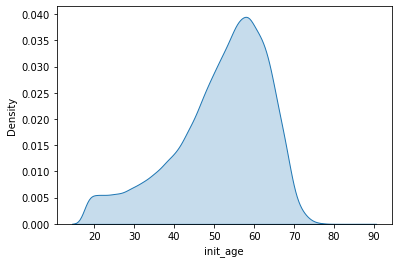

In [15]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, shade=True)
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

In [16]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()
d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns] < upper) & (d2[numerical_columns] > lower)]
d, d2 = d2, d

/tmp/ipykernel_31865/2675923900.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns] < upper) & (d2[numerical_columns] > lower)]
/tmp/ipykernel_31865/2675923900.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns] < upper) & (d2[numerical_columns] > lower)]


Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

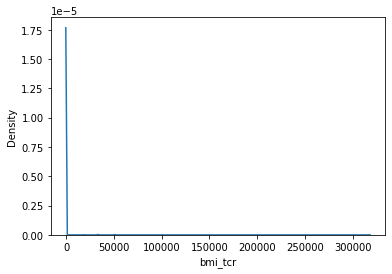

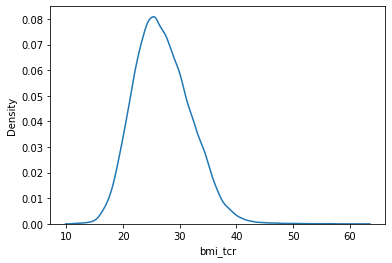

In [17]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [18]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_creat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 35


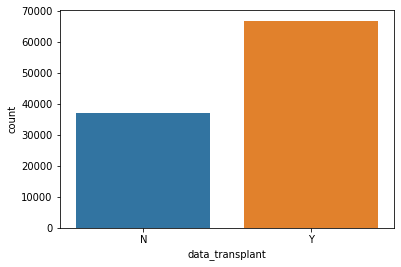

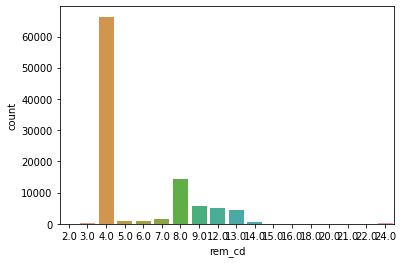

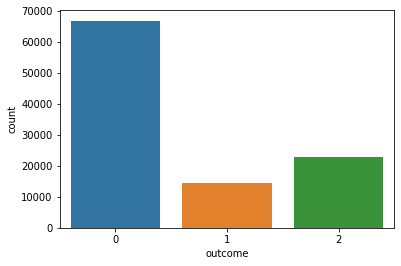

In [19]:
# 0 if transplant
# 1 if deceased
# 2 if removed for other reason
d["outcome"] = d.apply(
    lambda row: 
        0 if row.data_transplant == "Y" 
        else 1 if row.rem_cd == 8 
        else 2, axis=1)

# print distribution plot of data_transplant and rem_cd
sns.countplot(x="data_transplant", data=d)
plt.show()
sns.countplot(x="rem_cd", data=d)
plt.show()

# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [20]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True))

0   0.64271
2   0.21853
1   0.13876
Name: outcome, dtype: float64


In [21]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 27
Number date columns: 0
Number drug columns: 0


# Imputation and normalization

In [22]:
# impute numerical columns with mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())

# impute categorical columns with the most frequent value
d[categorical_columns] = d[categorical_columns].fillna(d[categorical_columns].mode().iloc[0])

# Normalization and encoding

Now, let's normalize numerical values.

In [23]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [24]:
# select categorical columns with more/less than 2 unique values
catgt2 = list(d[categorical_columns].nunique()[d[categorical_columns].nunique() > 2].index)
catlt2 = list(d[categorical_columns].nunique()[d[categorical_columns].nunique() <= 2].index)

# one hot encode
d = pd.get_dummies(d, columns=catgt2)
d = pd.get_dummies(d, columns=catlt2, drop_first=True) # drop redundant column

In [25]:
d.head()

,wgt_kg_tcr,hgt_cm_tcr,most_rcnt_creat,tot_serum_album,hemo_co_tcr,init_age,init_hgt_cm_calc,init_wgt_kg_calc,outcome,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_6.0,education_996.0,education_998.0,cereb_vasc_N,cereb_vasc_U,cereb_vasc_Y,abo_A,abo_A1,abo_A1B,abo_A2,abo_A2B,abo_AB,abo_B,abo_O,dial_ty_tcr_1.0,dial_ty_tcr_2.0,dial_ty_tcr_3.0,dial_ty_tcr_998.0,dial_ty_tcr_999.0,thoracic_dgn_2,thoracic_dgn_14,thoracic_dgn_100,thoracic_dgn_999,thoracic_dgn_1000,thoracic_dgn_1001,thoracic_dgn_1002,thoracic_dgn_1003,thoracic_dgn_1004,thoracic_dgn_1005,thoracic_dgn_1006,thoracic_dgn_1007,thoracic_dgn_1049,thoracic_dgn_1050,thoracic_dgn_1051,thoracic_dgn_1052,thoracic_dgn_1053,thoracic_dgn_1054,thoracic_dgn_1099,thoracic_dgn_1100,thoracic_dgn_1101,thoracic_dgn_1102,thoracic_dgn_1103,thoracic_dgn_1104,thoracic_dgn_1105,thoracic_dgn_1106,thoracic_dgn_1199,thoracic_dgn_1200,thoracic_dgn_1201,thoracic_dgn_1202,thoracic_dgn_1203,thoracic_dgn_1204,thoracic_dgn_1205,thoracic_dgn_1206,thoracic_dgn_1207,thoracic_dgn_1208,thoracic_dgn_1209,thoracic_dgn_1497,thoracic_dgn_1498,thoracic_dgn_1500,thoracic_dgn_1501,thoracic_dgn_1549,thoracic_dgn_1550,thoracic_dgn_1551,thoracic_dgn_1552,thoracic_dgn_1600,thoracic_dgn_1601,thoracic_dgn_1602,thoracic_dgn_1604,thoracic_dgn_1605,thoracic_dgn_1606,thoracic_dgn_1607,thoracic_dgn_1609,thoracic_dgn_1998,thoracic_dgn_1999,work_income_tcr_N,work_income_tcr_U,work_income_tcr_Y,malig_tcr_N,malig_tcr_U,malig_tcr_Y,prior_card_surg_tcr_N,prior_card_surg_tcr_U,prior_card_surg_tcr_Y,academic_level_tcr_1.0,academic_level_tcr_2.0,academic_level_tcr_3.0,academic_level_tcr_996.0,academic_level_tcr_998.0,func_stat_tcr_1.0,func_stat_tcr_2.0,func_stat_tcr_3.0,func_stat_tcr_996.0,func_stat_tcr_998.0,func_stat_tcr_2010.0,func_stat_tcr_2020.0,func_stat_tcr_2030.0,func_stat_tcr_2040.0,func_stat_tcr_2050.0,func_stat_tcr_2060.0,func_stat_tcr_2070.0,func_stat_tcr_2080.0,func_stat_tcr_2090.0,func_stat_tcr_2100.0,diab_1.0,diab_2.0,diab_3.0,diab_4.0,diab_5.0,diab_998.0,init_stat_2010.0,init_stat_2020.0,init_stat_2030.0,init_stat_2090.0,init_stat_2110.0,init_stat_2120.0,init_stat_2130.0,init_stat_2140.0,init_stat_2150.0,init_stat_2160.0,init_stat_2999.0,inotropic_Y,vas_Y,tah_Y,ethnicity_1,inotropes_tcr_1,ventilator_tcr_1,onvent_Y,ecmo_tcr_1,icu_Y,cig_use_Y,gender_M,iabp_tcr_1
0,-1.38209,-0.93023,0.00000,-0.00000,0.00000,0.80019,-0.93229,-1.38899,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.10065,-0.14235,-0.80089,-0.00000,-0.24486,-0.30978,-0.14392,-0.10222,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.97373,1.12737,1.09831,-0.00000,0.59072,1.22709,1.12658,1.98080,2,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0.80755,1.02397,0.11504,-0.00000,0.93178,1.22709,1.02312,0.80976,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
4,0.05269,-0.73377,0.00000,-0.00000,0.00000,0.03175,-0.73571,0.05176,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,

In [26]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 146


# Simple Logistic Regression Model

/home/wilmer/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6561599077455315
Macro f1 score: 0.3852541745194793


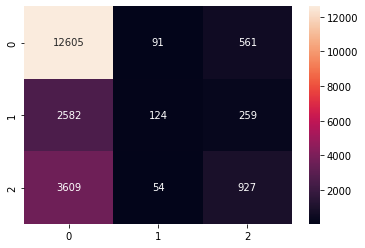

In [31]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)

# accuracy
print("Accuracy:", model.score(X_test, y_test))

# macro f1 score
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
print("Macro f1 score:", f1_score(y_test, y_pred, average="macro"))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [33]:
# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.95      0.79     13257
           1       0.46      0.04      0.08      2965
           2       0.53      0.20      0.29      4590

    accuracy                           0.66     20812
   macro avg       0.55      0.40      0.39     20812
weighted avg       0.61      0.66      0.58     20812



In [ ]:
# Perform forward feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

# drop transplant and deceased columns
X = d.drop("outcome", axis=1)
y = d["outcome"]

lr = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
rfecv = RFECV(estimator=lr, 
              step=1, 
              cv=5, 
              scoring="f1_macro", 
              verbose=1)

rfecv.fit(X, y)

In [ ]:
print("Optimal number of features: %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# print selected features
selected_features = X.columns[rfecv.support_]
print("Selected features:", selected_features)

# print features with low importance
low_importance_features = X.columns[rfecv.ranking_ > 1]
print("Low importance features:", low_importance_features)